# Yoga Pose Scoring

## Imports and Constants

In [1]:
import numpy as np
from collections import deque
import json
import mediapipe as mp
from mediapipe.tasks.python import vision
from mediapipe.tasks import python
import os
import cv2
import pandas as pd
from cv2 import IMREAD_UNCHANGED
import matplotlib.pyplot as plt

## Map Landmark Mapping

In [2]:
# def compute_angle(a, b, c):
#     """
#     Compute angle ABC (in degrees) given 3 points.
#     a, b, c are numpy arrays of shape (2,) or (3,)
#     """
#     ba = a - b
#     bc = c - b

#     cosine_angle = np.dot(ba, bc) / (
#         np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6
#     )
#     angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
#     return np.degrees(angle)

def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)

    if angle > 180.0:
        angle = 360-angle

    return angle


## Extract Pose Landmarks

In [3]:
# Create a PoseLandmarker object.
base_options = mp.tasks.BaseOptions(
    model_asset_path='pose_landmarker.task'
)
options = mp.tasks.vision.PoseLandmarkerOptions(
    base_options=base_options,
    running_mode=vision.RunningMode.IMAGE,
    output_segmentation_masks=True)
pose_landmarker = mp.tasks.vision.PoseLandmarker.create_from_options(options)

I0000 00:00:1770489138.458989 12160553 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1770489138.546243 12160554 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1770489138.581517 12160559 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


## Pose Normalization

In [4]:
def normalize_landmarks(landmarks):
    left_hip = landmarks[LANDMARKS["left_hip"]]
    right_hip = landmarks[LANDMARKS["right_hip"]]
    hip_center = (left_hip + right_hip) / 2

    left_shoulder = landmarks[LANDMARKS["left_shoulder"]]
    right_shoulder = landmarks[LANDMARKS["right_shoulder"]]
    shoulder_width = np.linalg.norm(left_shoulder - right_shoulder) + 1e-6

    normalized = (landmarks - hip_center) / shoulder_width
    return normalized


## Feature Extraction

In [5]:
def extract_joint_angles(lm):
    return {
        "left_knee": calculate_angle(
            lm[LANDMARKS["left_hip"]],
            lm[LANDMARKS["left_knee"]],
            lm[LANDMARKS["left_ankle"]],
        ),
        "right_knee": calculate_angle(
            lm[LANDMARKS["right_hip"]],
            lm[LANDMARKS["right_knee"]],
            lm[LANDMARKS["right_ankle"]],
        ),
        "left_hip": calculate_angle(
            lm[LANDMARKS["left_shoulder"]],
            lm[LANDMARKS["left_hip"]],
            lm[LANDMARKS["left_knee"]],
        ),
        "right_hip": calculate_angle(
            lm[LANDMARKS["right_shoulder"]],
            lm[LANDMARKS["right_hip"]],
            lm[LANDMARKS["right_knee"]],
        ),
        "left_elbow": calculate_angle(
            lm[LANDMARKS["left_shoulder"]],
            lm[LANDMARKS["left_elbow"]],
            lm[LANDMARKS["left_wrist"]],
        ),
        "right_elbow": calculate_angle(
            lm[LANDMARKS["right_shoulder"]],
            lm[LANDMARKS["right_elbow"]],
            lm[LANDMARKS["right_wrist"]],
        ),
    }


## Reference Pose Detection

In [6]:
LANDMARKS = {
    "left_shoulder": 11,
    "right_shoulder": 12,
    "left_elbow": 13,
    "right_elbow": 14,
    "left_wrist": 15,
    "right_wrist": 16,
    "left_hip": 23,
    "right_hip": 24,
    "left_knee": 25,
    "right_knee": 26,
    "left_ankle": 27,
    "right_ankle": 28
}

ANGLE_TOLERANCE = 15.0

# lm = json.load(open('yoga_landmarks/tree_2.json'))
# lm = pd.read_json('yoga_landmarks/tree_2.json')
# lm = np.array(lm)
# reference_angles = extract_joint_angles(lm) 
with open('yoga_pose_ground_truth.json', 'r') as f:
    pose_library = json.load(f)

reference_angles = pose_library["Vrksasana"]


## MAE Based Pose Scoring

In [7]:
# def compute_weighted_mae(user_angles, ref_angles, weights):
#     total_error = 0.0

#     for joint, ref_angle in ref_angles.items():
#         if joint not in user_angles:
#             continue
#         error = abs(user_angles[joint] - ref_angle)
#         total_error += weights[joint] * error

#     return total_error


## Convert MAE to Score (0 - 100)

In [8]:
def get_shortest_angle_distance(a, b):
    """Calculates the shortest distance between two angles in degrees."""
    diff = (b - a + 180) % 360 - 180
    return abs(diff)

def mae_to_score(mae, tolerance=ANGLE_TOLERANCE):
    # sigma = tolerance
    # score = np.exp(-0.5 * (mae / sigma) ** 2)
    # return score * 100
    
    if mae <= tolerance:
        return 100.0
    cutoff = 45.0
    score = max(0.0, 1.0 - (mae - tolerance) / (cutoff - tolerance))
    # score = max(0.0, 1.0 - mae / tolerance)
    return score * 100

def compute_mae(user_angles, reference_pose):
    total_error = 0.0
    total_weight = 0.0

    for joint, ref_angle in reference_pose.items():
        if joint not in user_angles:
            continue
        error = get_shortest_angle_distance(user_angles[joint], ref_angle)
        total_error += error
        # total_error += abs(user_angles[joint] - ref_angle)
        total_weight += 1

    return total_error / (total_weight + 1e-6)

## Pose Scoring Pipeline

In [9]:
def load_image(image_path):
    image = cv2.imread(image_path, IMREAD_UNCHANGED)
    if image is None:
        raise ValueError("Image not found")
    return image

In [10]:
def score_pose_from_image(image):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert to MediaPipe Image
    mp_image = mp.Image(
        image_format=mp.ImageFormat.SRGB,
        data=rgb
    )

    # Run pose landmarker
    result = pose_landmarker.detect(mp_image)

    if not result.pose_landmarks:
        return None

    # Extract landmarks (first detected person)
    landmarks = result.pose_landmarks[0]

    # Convert to numpy array (x, y only)
    landmarks_np = np.array(
        [[lm.x, lm.y] for lm in landmarks]
    )

    # Normalize + extract features
    landmarks_np = normalize_landmarks(landmarks_np)
    angles = extract_joint_angles(landmarks_np)

    # Score
    # reference_pose = get_tree_pose_reference(angles)
    # mae = weighted_mae(angles, reference_pose, POSE_WEIGHTS)
    mae = compute_mae(angles, reference_angles)
    score = mae_to_score(mae)


    return {
        "score": round(score, 2),
        "mae": round(mae, 2),
        "angles": angles,
        "reference angles": reference_angles,
        "landmarks": landmarks,
    }


In [11]:
# image = load_image("/Users/weijie/Downloads/archive/Vrksasana/File12.png")
# image = load_image("images/tree_2.jpg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [12]:
def show_result(image, show_plot):
    result = score_pose_from_image(image)
    landmark_list = result["landmarks"]

    if show_plot:
        annotated_image = image.copy()
        for idx, landmark in enumerate(landmark_list):
            x, y = int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0])
            cv2.circle(annotated_image, (x, y), 5, (0, 255, 0), -1)

            # Draw connections
            connections = mp.tasks.vision.PoseLandmarksConnections.POSE_LANDMARKS
            for connection in connections:
                start_idx = connection.start
                end_idx = connection.end
                start_point = (int(landmark_list[start_idx].x * image.shape[1]),
                                int(landmark_list[start_idx].y * image.shape[0]))
                end_point = (int(landmark_list[end_idx].x * image.shape[1]),
                                int(landmark_list[end_idx].y * image.shape[0]))
                cv2.line(annotated_image, start_point, end_point, (255, 0, 0), 2)
            
        plt.figure(figsize=(10, 10))
        plt.imshow(annotated_image)
        plt.axis('off')
        plt.show()
    return result

W0000 00:00:1770489138.801541 12160560 landmark_projection_calculator.cc:81] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


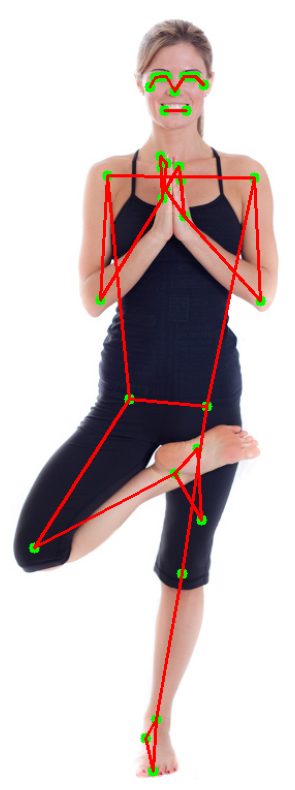

score: 100.0
mae: 4.34
angles:
	left_knee: 175.1976006784749
	right_knee: 18.545903509669078
	left_hip: 171.92833211205294
	right_hip: 104.48377854866746
	left_elbow: 60.02730467110957
	right_elbow: 49.83606356888863
reference angles:
	left_elbow: 49.9
	right_elbow: 42.9
	left_shoulder: 56.2
	right_shoulder: 49.0
	left_knee: 173.9
	right_knee: 17.7
	left_hip: 170.9
	right_hip: 98.7
landmarks: [NormalizedLandmark(x=0.5976853966712952, y=0.10599121451377869, z=-1.350242257118225, visibility=0.9992707371711731, presence=0.999085545539856, name=None), NormalizedLandmark(x=0.6325125098228455, y=0.08612522482872009, z=-1.2623035907745361, visibility=0.9994052648544312, presence=0.9983434677124023, name=None), NormalizedLandmark(x=0.6543989777565002, y=0.08621221780776978, z=-1.262701392173767, visibility=0.9993544220924377, presence=0.998397171497345, name=None), NormalizedLandmark(x=0.6717721819877625, y=0.08668866753578186, z=-1.2630789279937744, visibility=0.9993646740913391, presence=0.9

In [13]:
image = load_image("/Users/weijie/Downloads/archive/Vrksasana/File20.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

result = show_result(image, show_plot=True) # show plot = False to disable plot

for k, v in result.items():
    if k == 'angles' or k == 'reference angles':
        print(f"{k}:")
        for angle_k, angle_v in v.items():
            print(f"\t{angle_k}: {angle_v}")
    else:
        print(f"{k}: {v}")

## In Camera Loop

In [14]:
# class StabilityTracker:
#     def __init__(self, window_size=30):
#         self.window_size = window_size
#         self.angle_history = deque(maxlen=window_size)

#     def update(self, angles):
#         self.angle_history.append(list(angles.values()))

#     def stability_score(self):
#         if len(self.angle_history) < 5:
#             return 1.0  # not enough data to penalize

#         variance = np.var(self.angle_history)
#         stability = np.exp(-variance)
#         return stability


In [15]:
# def score_pose(landmarks, stability_tracker=None):
#     # Normalize
#     landmarks = normalize_landmarks(landmarks)
# 
#     # Extract angles
#     user_angles = extract_joint_angles(landmarks)
# 
#     # MAE scoring
#     mae = compute_weighted_mae(
#         user_angles,
#         TREE_POSE_REFERENCE,
#         TREE_POSE_WEIGHTS
#     )
# 
#     base_score = mae_to_score(mae)
# 
#     # Stability bonus
#     if stability_tracker:
#         stability_tracker.update(user_angles)
#         stability = stability_tracker.stability_score()
#         final_score = base_score * stability
#     else:
#         final_score = base_score
# 
#     return {
#         "score": round(final_score, 2),
#         "mae": round(mae, 2),
#         "angles": user_angles
#     }
# 

In [16]:
# stability_tracker = StabilityTracker(window_size=45)
# 
# # landmarks should be a (33, 2) or (33, 3) numpy array from MediaPipe
# # Example:
# # landmarks = np.array([[x0,y0], [x1,y1], ...])
# 
# result = score_pose(landmarks, stability_tracker)
# 
# print("Score:", result["score"])
# print("MAE:", result["mae"])
# 